# BA 820 Homework 2



## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). We have already curated the data for you in the `data/enron` directory, with one file per email (so there is no need to redownload the dataset as it is already included in this homework zip archive). The dataset includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam.

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the `make_word_list` function, construct a list of processed documents.

In [1]:
import re
import string
import codecs

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [2]:
## Write your code here
import spacy
import glob

files = glob.glob('./data/enron/*.txt')
list_of_processed_docs = []

for doc in files:
    list_of_processed_docs.append(make_word_list(doc))

len(list_of_processed_docs)

5171

### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [3]:
## Write your code here
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=50, stop_words="english", max_df=0.8)
X = vectorizer.fit_transform(list_of_processed_docs) #did the tfidf for this data
len(vectorizer.vocabulary_)

1680

### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix `X` using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [4]:
## Write your code here
from sklearn.mixture import GaussianMixture 
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_tsne2d = tsne.fit_transform(X)

gmm = GaussianMixture(n_components = 3) 
gmm.fit(X_tsne2d) 

weight = gmm.weights_
for i in range(len(weight)):
    print("Cluster", i, "has", int(round(weight[i]*X.shape[0])), "points")

/Users/nini/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/nini/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Cluster 0 has 2142 points
Cluster 1 has 1454 points
Cluster 2 has 1575 points


### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes the following parameters:
    - `X` is a matrix of TF-IDF features (rows index documents, columns index terms).
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [5]:
def plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

In [6]:
## Write your code here
gmm_cluster_assignments = gmm.predict(X_tsne2d)
vect_list = list(vectorizer.vocabulary_.keys())

In [7]:
a = vect_list.index("regards")
b = vect_list.index("available")
c = vect_list.index("performance")
list_hammy = list([a,b,c])

d = vect_list.index("peopie")
e = vect_list.index("oniy")
f = vect_list.index("wiil")
list_spammy = list([d,e,f])

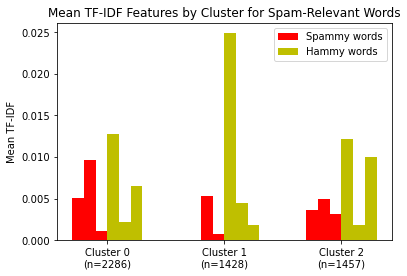

In [8]:
plot_spam_words_by_cluster(X, gmm_cluster_assignments, 3, list_spammy, list_hammy)

### Part E: Interpret results [10 points]

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

*** WRITE YOUR ANSWER HERE IN TEXT ***

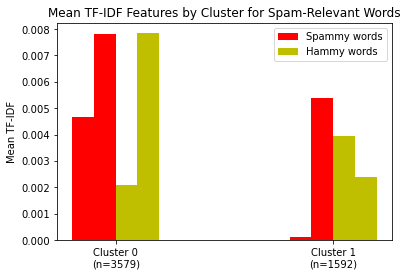

In [9]:
gmm_2 = GaussianMixture(n_components = 2) 
gmm_2.fit(X_tsne2d) 

gmm_2_cluster_assignments = gmm_2.predict(X_tsne2d)

plot_spam_words_by_cluster(X, gmm_2_cluster_assignments, 2, list_spammy[:2], list_hammy[:2])

If we only have two cAfter reducing the number of clusters from 3 to 2, we can see that the accuracy of cluster prediction is lower, shown by a higher frequency of spammy words comparing with hammy words. This could be the issue of over-generalization because few clusters may group words that are dissimilar together.lusters, then the spammy words are significantly less frequent than hammy words.

## Question 2: Latent "Purposes" in Mobile Apps [50 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [11]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [12]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [13]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [14]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.values
#del df # uncomment to free up RAM
#del df_perms # uncomment to free up RAM

In [15]:
## check the shape of X
X.shape

(180295, 173)

### Part C: Downweight "stopwords" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [16]:
## Write your code here
# compute TF-IDF scores
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

transformer = TfidfTransformer()
tfidf = transformer.fit_transform(X)

### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [37]:
%%time
## Write your code here 
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, max_iter=10,
                                learning_method='online',
                                n_jobs=-1,
                                random_state=0)
lda.fit(tfidf)

CPU times: user 52.5 s, sys: 4.77 s, total: 57.3 s
Wall time: 1min 30s


LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=0)

Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

In [38]:
## Write your code here
for topic_idx, topic in enumerate(lda.components_):
    message = "Topic #%d: " % (topic_idx+1)
    message += "\n"
    message += ", ".join([permission_columns[i]
                         for i in topic.argsort()[:-10 - 1:-1]])
    print(message + '\n')

Topic #1: 
Your location : coarse (network-based) location (D), Your location : fine (GPS) location (D), Network communication : full Internet access (D), Network communication : view network state (S), Phone calls : read phone state and identity (D), Storage : modify/delete USB storage contents modify/delete SD card contents (D), Hardware controls : record audio (D), Your location : access extra location provider commands (S), Default : permission to install a location provider (S), Network communication : download files without notification (S)

Topic #2: 
Hardware controls : control vibrator (S), System tools : prevent device from sleeping (D), Network communication : full Internet access (D), Storage : modify/delete USB storage contents modify/delete SD card contents (D), Network communication : view network state (S), System tools : allow Wi-Fi Multicast reception (D), Default : force application to close (S), Phone calls : read phone state and identity (D), Default : modify/delet

*** WRITE YOUR ANSWER HERE IN TEXT ***

Topic #4: permissions could be relevant for web browsers or other internet-connected apps that need to access or modify browsing history, bookmarks, or other personal data.

Topic #5: permissions could be relevant for system tools and hardware controls.

Topic #10: permission could be relevant for location-based apps or services that need to access or provide GPS or network-based location data, such as a navigation app or a weather app.

### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [25]:
## Write your code here
topic_results = lda.transform(tfidf)

In [26]:
index_100000 = df[df["Number of ratings"] >= 100000].index
lst = []
for i in index_100000:
    poss_lst = topic_results[i].round(2).tolist()
    poss_lst.append(df.loc[i, 'App'])
    lst.append(poss_lst)
    

df_topic = pd.DataFrame(lst, columns=['topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 
                                      'topic7', 'topic8', 'topic9', 'topic10', 'APP'])
df_topic

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,APP
0,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.06,0.79,Google Maps
1,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.82,Facebook for Android
2,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.54,0.27,Pandora?? internet radio
3,0.03,0.03,0.03,0.03,0.13,0.03,0.03,0.03,0.03,0.65,Zedge Ringtones & Wallpapers
4,0.03,0.03,0.03,0.18,0.03,0.03,0.56,0.03,0.03,0.03,Advanced Task Killer
...,...,...,...,...,...,...,...,...,...,...,...
90,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.54,0.27,Pandora® internet radio
91,0.02,0.02,0.02,0.46,0.08,0.02,0.11,0.02,0.02,0.22,Dolphin Browser™ HD
92,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.34,0.45,Brightest Flashlight Free™
93,0.02,0.02,0.02,0.02,0.09,0.02,0.10,0.02,0.07,0.63,Handcent SMS


In [27]:
for name in df_topic.loc[:, df_topic.columns != 'APP'].columns:
    print(name)
    print(df_topic.nlargest(3, name)['APP'])
    print("\n")

topic1
12      Dictionary.com
85    Air Control Lite
83          Paper Toss
Name: APP, dtype: object


topic2
67            Tank Hero
71    Robo Defense FREE
61          Fruit Slice
Name: APP, dtype: object


topic3
38    SpeechSynthesis Data Installer
42                         Ringdroid
44                    Google Sky Map
Name: APP, dtype: object


topic4
25    Seesmic (Facebook, Twitter)
79                    Zynga Poker
46          Dolphin Browser??? HD
Name: APP, dtype: object


topic5
81      Strip Poker
48    Wallpapers HD
9            Shazam
Name: APP, dtype: object


topic6
58      Angry Birds Seasons
65          Yoo Ninja! Free
28    Adobe Flash Player 11
Name: APP, dtype: object


topic7
30                  Netflix
63    Ant Smasher Free Game
73            Bunny Shooter
Name: APP, dtype: object


topic8
66    Blast Monkeys
62      Racing Moto
68       My Country
Name: APP, dtype: object


topic9
6           Tiny Flashlight + LED
23                 Battery Widget
70    Inoti

### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [15 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

/Users/nini/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


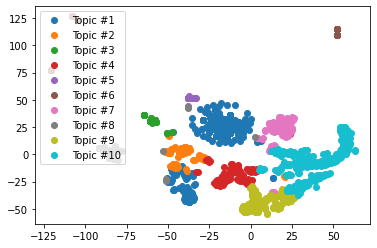

CPU times: user 13 s, sys: 3.07 s, total: 16.1 s
Wall time: 3.35 s


In [35]:
%%time
## Write your code here
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, angle=0.99, init='pca', perplexity=30, learning_rate=600, random_state=0)

tsne_embedding = tsne.fit_transform(topic_results[:1200, :])  #fit 1200 documents

most_probable_topic = np.argmax(topic_results, axis=1)[:1200]

for topic in range(10):
    plt.plot(tsne_embedding[most_probable_topic==topic,0], tsne_embedding[most_probable_topic==topic,1],
             'o', label="Topic #" + str(topic+1))

plt.legend(loc='upper left')
plt.show()